In [1]:
import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Add,Reshape,AveragePooling2D,ZeroPadding2D,BatchNormalization,MaxPool2D,Conv1D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from tensorflow.keras import layers
import tensorflow.keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform as glorot_uniform
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

In [2]:
f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
# idx = np.random.choice(range(0,sample_num),size=3375)
idx = np.random.choice(range(0,sample_num),size=60000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    if i%1 == 0:
        !free -m
    '''if i == 10:
        continue'''
    filename = 'ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


              total        used        free      shared  buff/cache   available
Mem:          64362       13483       44087          40        6790       50333
Swap:           976         971           5
ExtractDataset/part1.h5
              total        used        free      shared  buff/cache   available
Mem:          64362       13970       43600          40        6791       49846
Swap:           976         971           5
ExtractDataset/part2.h5
              total        used        free      shared  buff/cache   available
Mem:          64362       14463       43107          40        6791       49353
Swap:           976         971           5
ExtractDataset/part3.h5
              total        used        free      shared  buff/cache   available
Mem:          64362       14946       42625          40        6791       48870
Swap:           976         971           5
ExtractDataset/part4.h5
              total        used        free      shared  buff/cache   available
Mem:    

## Data preprocessing, and obtain training set and test set

In [3]:
n_examples = X.shape[0]
# n_train = int(n_examples * 0.9877) 
n_train = int(n_examples * 0.8)  
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (1152000, 1024, 2)
Y_train: (1152000, 24)
X_test: (288000, 1024, 2)
Y_test: (288000, 24)


In [4]:
X_train[0]

array([[ 0.07898445, -0.20260288],
       [ 0.11095233, -0.33055928],
       [ 0.18579495, -0.5502346 ],
       ...,
       [ 0.00152265, -0.00701595],
       [-0.02117801,  0.04212612],
       [-0.00710661,  0.08557183]], dtype=float32)

In [5]:
X_train.shape[1:] 
# Input(in_shp)

(1024, 2)

In [6]:
units = round((X_train.shape[0])/(0.2*(X_train.shape[1]+X_train.shape[2])))
units/7

802.0

In [7]:
# #FULL RESNET
# def identity_block(X, f, filters, stage, block):
#     """
#     Implementation of the identity block as defined in Figure 3
    
#     Arguments:
#     X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
    
#     Returns:
#     X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
#     """
    
#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value. You'll need this later to add back to the main path. 
#     X_shortcut = X
    
#     # First component of main path
#     X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

    
#     # Second component of main path (≈3 lines)
#     X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)

#     # Third component of main path (≈2 lines)
#     X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
    
#     return X

# def convolutional_block(X, f, filters, stage, block, s = 2):

#     """
#     Implementation of the convolutional block as defined in Figure 4
    
#     Arguments:
#     X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
#     f -- integer, specifying the shape of the middle CONV's window for the main path
#     filters -- python list of integers, defining the number of filters in the CONV layers of the main path
#     stage -- integer, used to name the layers, depending on their position in the network
#     block -- string/character, used to name the layers, depending on their position in the network
#     s -- Integer, specifying the stride to be used
    
#     Returns:
#     X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
#     """
    
#     # defining name basis
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
    
#     # Retrieve Filters
#     F1, F2, F3 = filters
    
#     # Save the input value
#     X_shortcut = X


#     ##### MAIN PATH #####
#     # First component of main path 
#     X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)

#     # Second component of main path (≈3 lines)
#     X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)


#     # Third component of main path (≈2 lines)
#     X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


#     ##### SHORTCUT PATH #### (≈2 lines)
#     X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
#                         kernel_initializer = glorot_uniform(seed=0),data_format="channels_first")(X_shortcut)
#     X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

#     # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
    
    
#     return X

# def ResNet50(input_shape=(64, 64, 3), classes=6):
#     """
#     Implementation of the popular ResNet50 the following architecture:
#     CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
#     -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

#     Arguments:
#     input_shape -- shape of the images of the dataset
#     classes -- integer, number of classes

#     Returns:
#     model -- a Model() instance in Keras
#     """
#     mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
#     with mirrored_strategy.scope():
#         # Define the input as a tensor with shape input_shape
#         X_input = Input(input_shape)
#         X = Reshape([1,1024,2], input_shape=in_shp)(X_input)

#         # Zero-Padding
#         X = ZeroPadding2D((3, 3))(X)

#         # Stage 1
#         X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
#         X = BatchNormalization(axis=3, name='bn_conv1')(X)
#         X = Activation('relu')(X)
#         X = MaxPooling2D((3, 3), strides=(2, 2),data_format="channels_first")(X)

#         # Stage 2
#         X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
#         X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
#         X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

#         ### START CODE HERE ###

#         # Stage 3 (≈4 lines)
#         X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
#         X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
#         X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
#         X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

#         # Stage 4 (≈6 lines)
#         X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
#         X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

#         # Stage 5 (≈3 lines)
#         X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
#         X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
#         X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

#         # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
#         X = AveragePooling2D((2,2), name="avg_pool")(X)

#         ### END CODE HERE ###

#         # output layer
#         X = Flatten()(X)
#         X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


#         # Create model
#         model = Model.Model(inputs = X_input, outputs = X, name='ResNet50')

#     return model

In [8]:
# classes = ['32PSK',
#  '16APSK',
#  '32QAM',
#  'FM',
#  'GMSK',
#  '32APSK',
#  'OQPSK',
#  '8ASK',
#  'BPSK',
#  '8PSK',
#  'AM-SSB-SC',
#  '4ASK',
#  '16PSK',
#  '64APSK',
#  '128QAM',
#  '128APSK',
#  'AM-DSB-SC',
#  'AM-SSB-WC',
#  '64QAM',
#  'QPSK',
#  '256QAM',
#  'AM-DSB-WC',
#  'OOK',
#  '16QAM']

   
# in_shp = X_train.shape[1:]   #Dimensions of each sample
# model = ResNet50(input_shape = in_shp, classes = 24)
# model.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.LazyAdam(),metrics=['accuracy'])
# model.summary()

In [9]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

   
def residual_stack(X,Filters,Seq,max_pool):
    #1*1 Conv Linear
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    #Residual Unit 1
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #Residual Unit 2
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #MaxPooling
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    return X

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
with mirrored_strategy.scope():

    in_shp = X_train.shape[1:]   #Dimensions of each sample
    #input layer
    X_input = Input(in_shp)
    X = Reshape([1,1024,2], input_shape=in_shp)(X_input)
    #Residual Srack 1
    X = residual_stack(X,32,"ReStk1",False)  #shape:(1,512,32)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    #Residual Srack 2
    X = residual_stack(X,32,"ReStk2",True)  #shape:(1,256,32)
    #Residual Srack 3
    X = residual_stack(X,64,"ReStk3",True)  #shape:(1,128,32)
    #Residual Srack 4
    X = residual_stack(X,64,"ReStk4",True)  #shape:(1,64,32)
    #Residual Srack 5
    # X = residual_stack(X,32,"ReStk5",True)  #shape:(1,32,32)
    # #Residual Srack 6
    # X = residual_stack(X,32,"ReStk6",True)  #shape:(1,16,32)
    #Full Con 1
    X = Flatten()(X)
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
    X = Dropout(0.3)(X)
    #Full Con 2
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
    X = Dropout(0.3)(X)
    #Full Con 3
    X = Dense(len(classes), kernel_initializer='he_normal', name="dense3")(X)
    #SoftMax
    X = Activation('softmax')(X)
    #Create Model
    model = Model.Model(inputs=X_input,outputs=X)
model.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.LazyAdam(),metrics=['accuracy'])
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

In [10]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%%time
# filepath = 'transformer_model.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=100,
    verbose=1,
#     validation_data=(X_test, Y_test),
    validation_split = 0.2,
    callbacks = [
#         tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost

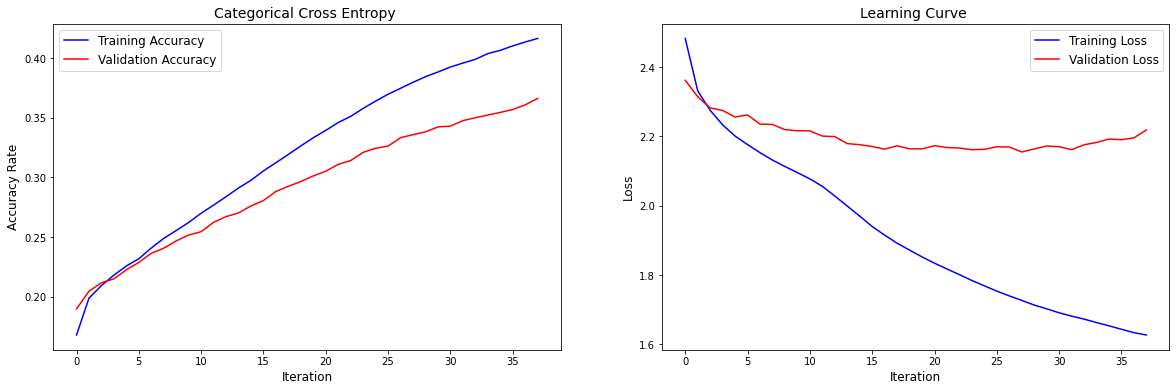

In [34]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy ',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [22]:
model = load_model(filepath)

NameError: name 'filepath' is not defined

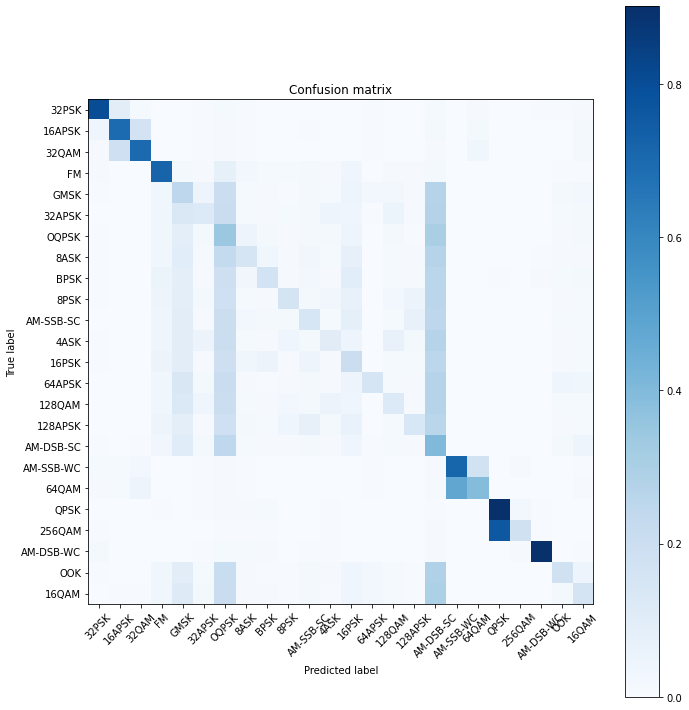

In [35]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [36]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.8013289595424342
16APSK 0.6953420058749475
32QAM 0.6995407098121086
FM 0.7208815149991621
GMSK 0.24778834229020255
32APSK 0.12048784480641729
OQPSK 0.34160449325173947
8ASK 0.14923891462607544
BPSK 0.1661484158332633
8PSK 0.15559614745931585
AM-SSB-SC 0.14097463948284436
4ASK 0.10004178854993731
16PSK 0.20164643272908697
64APSK 0.15361903155053147
128QAM 0.12253198881450725
128APSK 0.14030846185910797
AM-DSB-SC 0.4047221758718505
AM-SSB-WC 0.7167227097514968
64QAM 0.39302575996024186
QPSK 0.9012704475628996
256QAM 0.17608442745554262
AM-DSB-WC 0.894754539340955
OOK 0.1768475366178429
16QAM 0.16093478080716003


Overall Accuracy -20:  0.46174096174096174
Overall Accuracy -18:  0.46674898571176576
Overall Accuracy -16:  0.4507004066877542
Overall Accuracy -14:  0.4775991056840657
Overall Accuracy -12:  0.4544008483563097
Overall Accuracy -10:  0.47771407434806734
Overall Accuracy -8:  0.48434864104967196
Overall Accuracy -6:  0.4784366576819407
Overall Accuracy -4:  0.44926617140786373
Overall Accuracy -2:  0.3796213609573138


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Overall Accuracy 0:  0.31240359314036836
Overall Accuracy 2:  0.3160865475070555
Overall Accuracy 4:  0.2964001447178003
Overall Accuracy 6:  0.3071440987310968
Overall Accuracy 8:  0.3093952483801296
Overall Accuracy 10:  0.30637471304962033
Overall Accuracy 12:  0.305764192139738
Overall Accuracy 14:  0.3000647488668948
Overall Accuracy 16:  0.3004182578650664
Overall Accuracy 18:  0.30844243792325055
Overall Accuracy 20:  0.30844036697247706
Overall Accuracy 22:  0.3104242656939912
Overall Accuracy 24:  0.31302539998192175
Overall Accuracy 26:  0.3080895008605852
Overall Accuracy 28:  0.3082706766917293
Overall Accuracy 30:  0.30367045154475836


<Figure size 432x288 with 0 Axes>

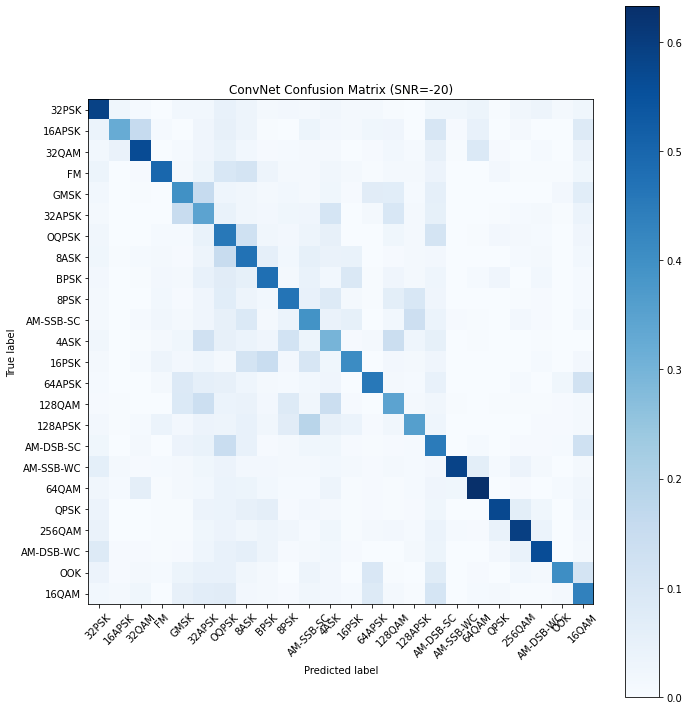

<Figure size 432x288 with 0 Axes>

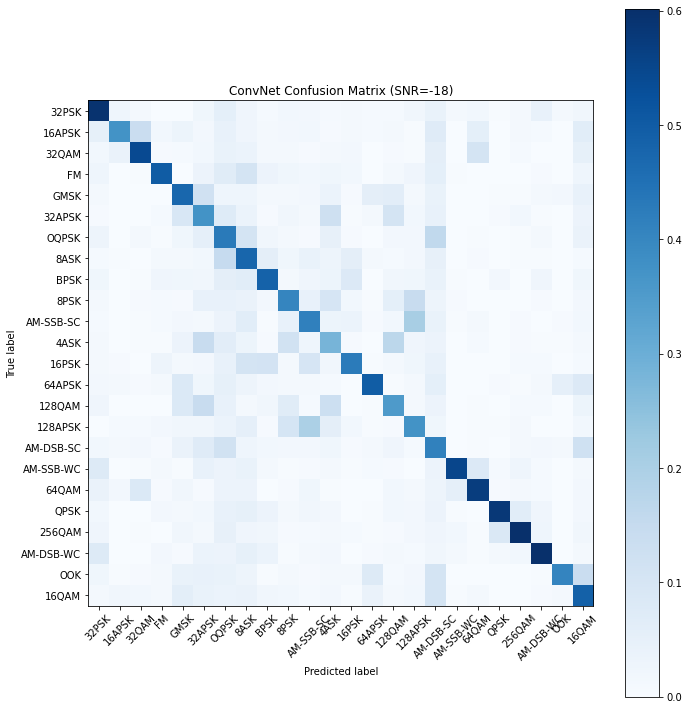

<Figure size 432x288 with 0 Axes>

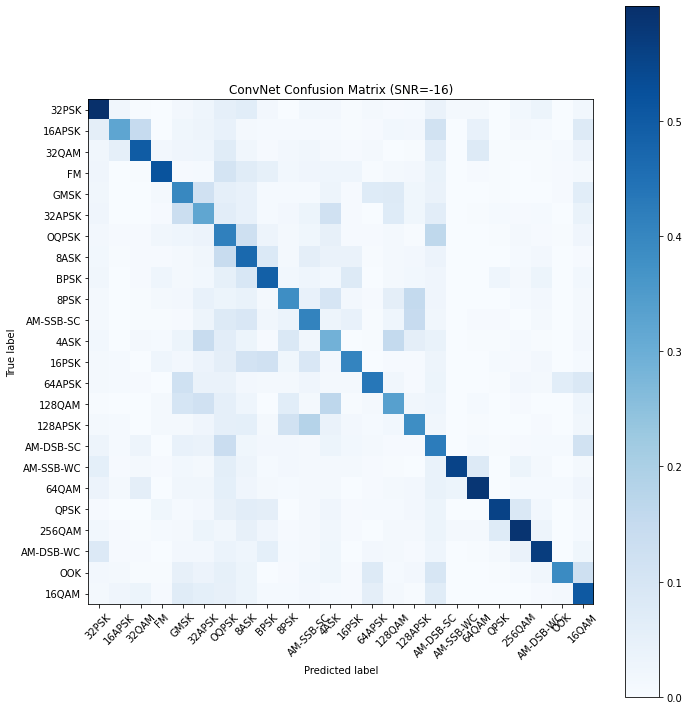

<Figure size 432x288 with 0 Axes>

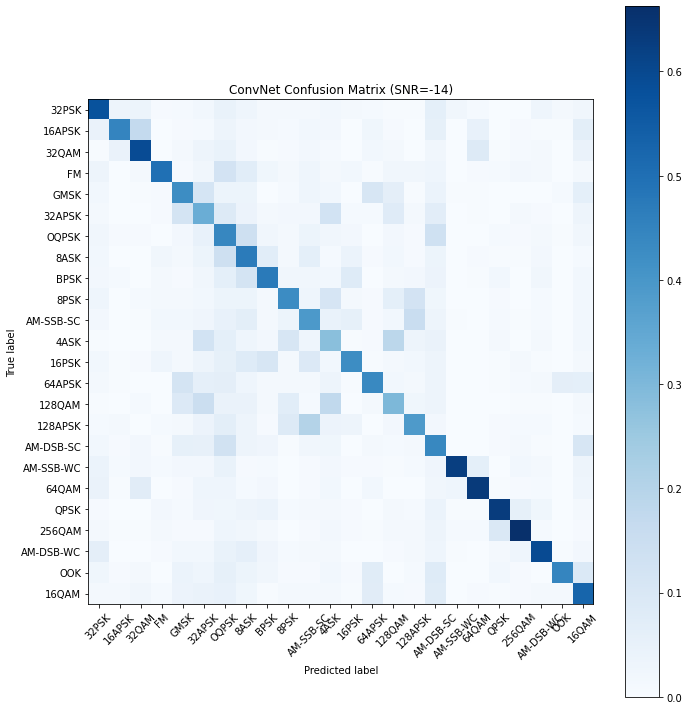

<Figure size 432x288 with 0 Axes>

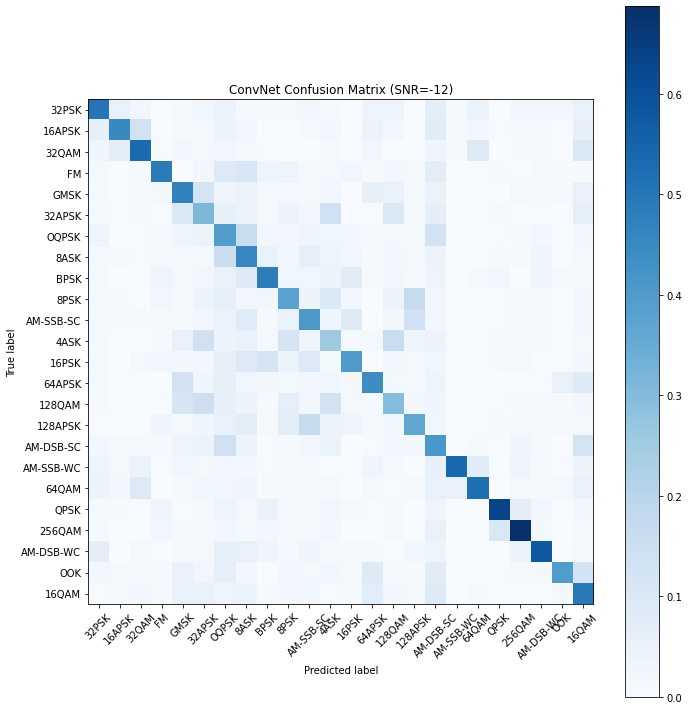

<Figure size 432x288 with 0 Axes>

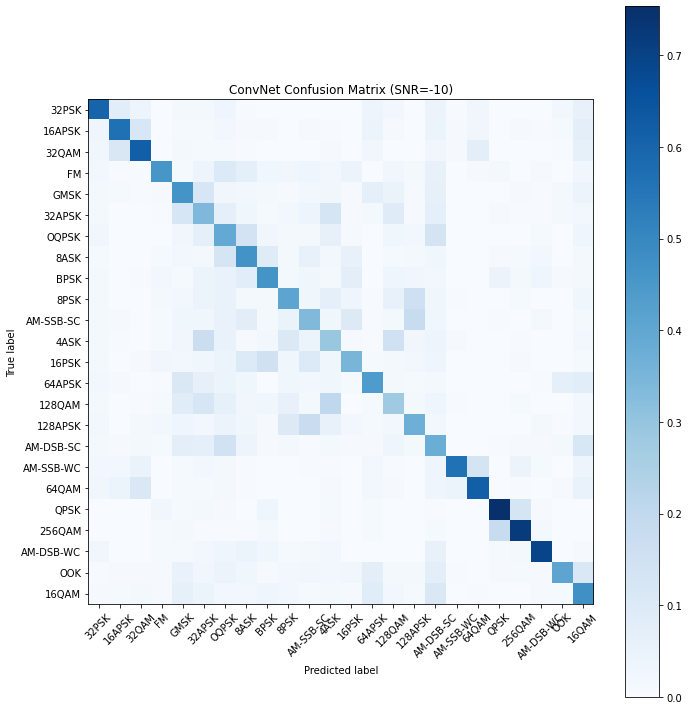

<Figure size 432x288 with 0 Axes>

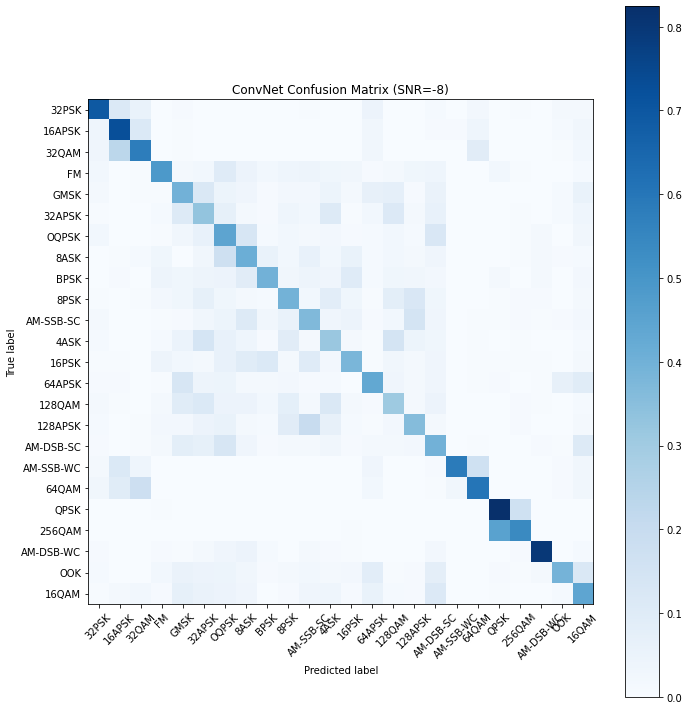

<Figure size 432x288 with 0 Axes>

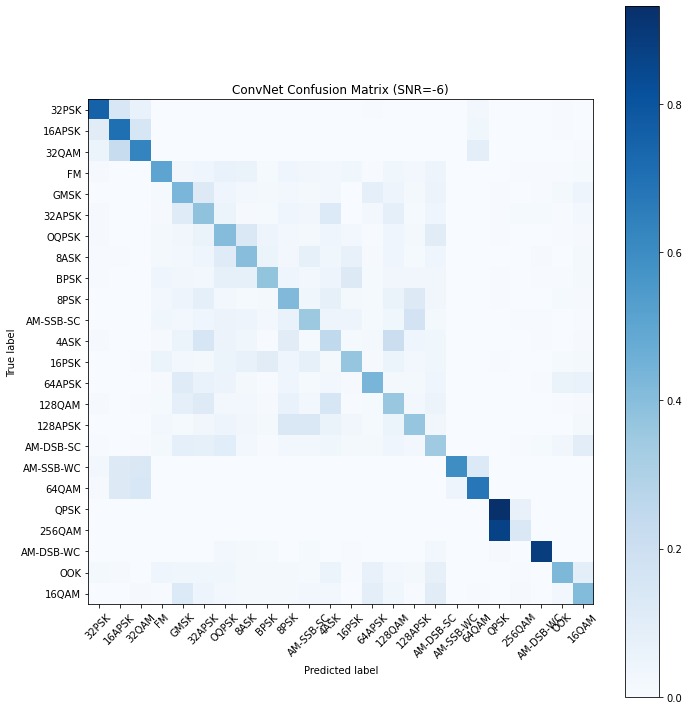

<Figure size 432x288 with 0 Axes>

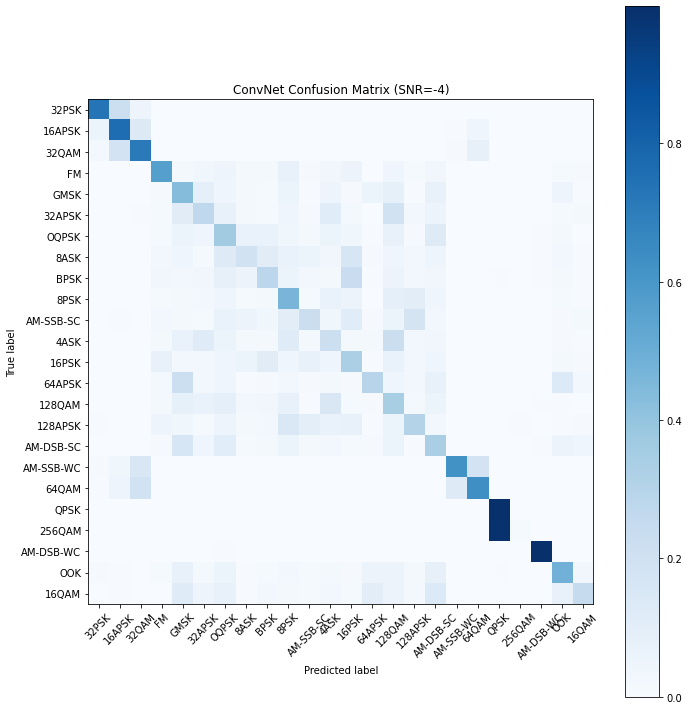

<Figure size 432x288 with 0 Axes>

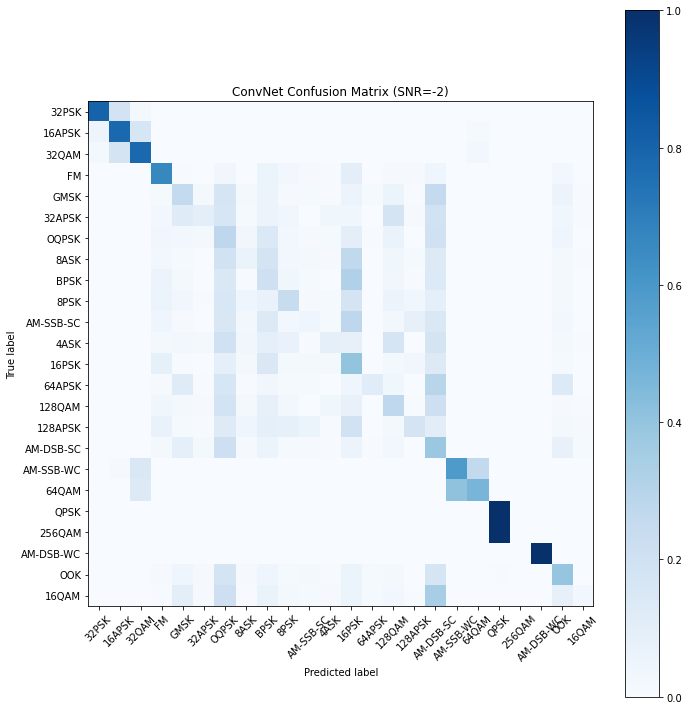

<Figure size 432x288 with 0 Axes>

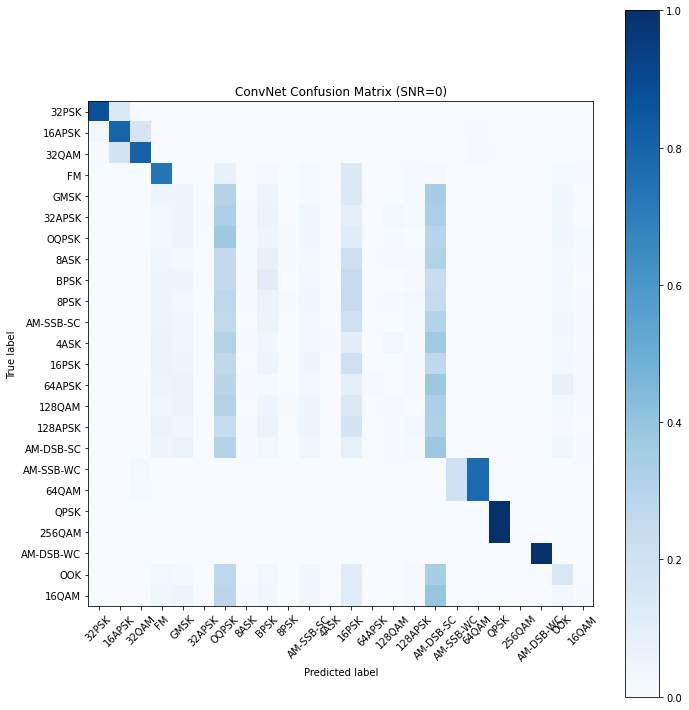

<Figure size 432x288 with 0 Axes>

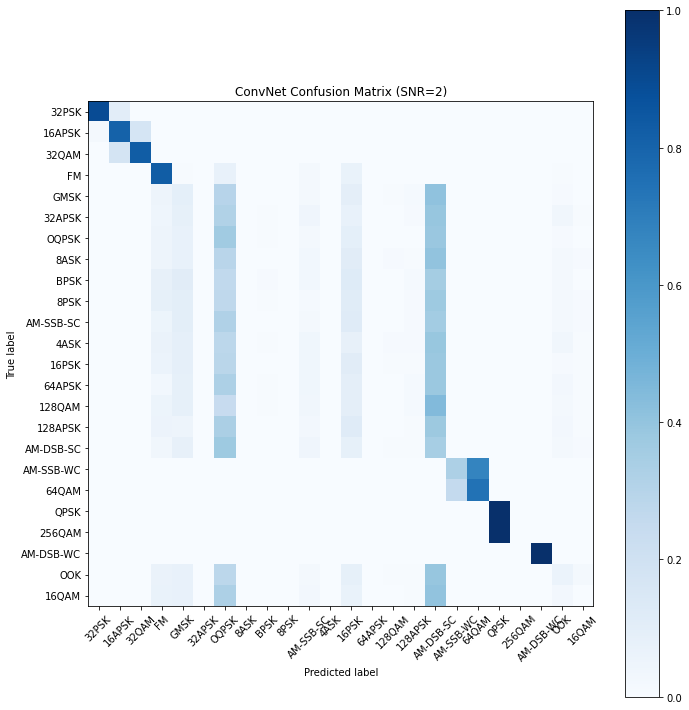

<Figure size 432x288 with 0 Axes>

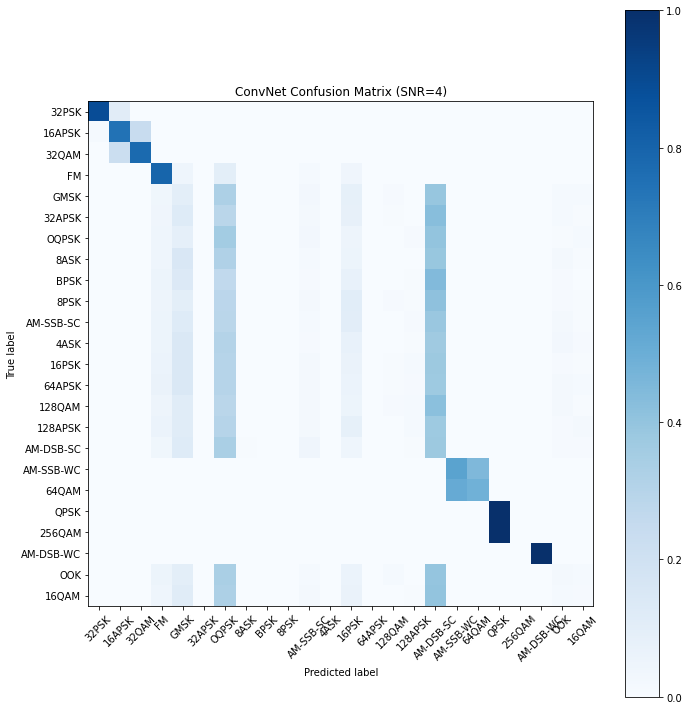

<Figure size 432x288 with 0 Axes>

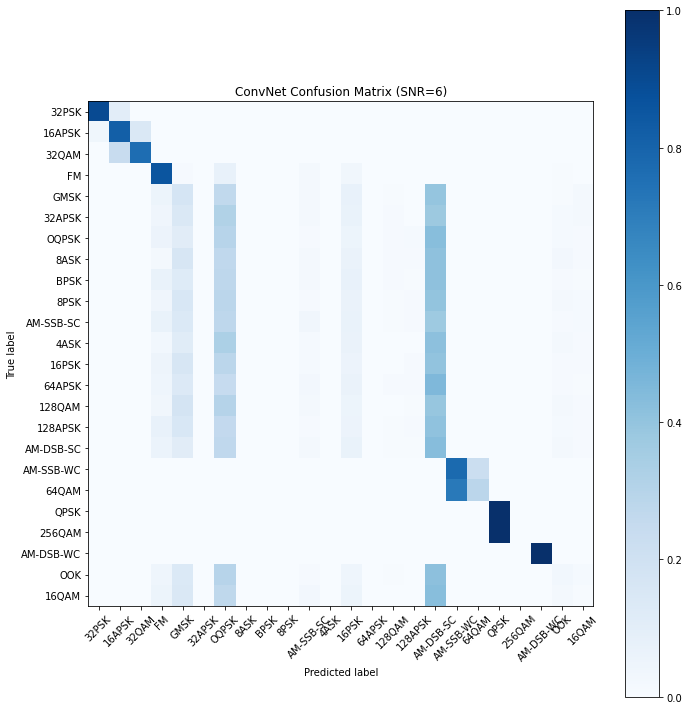

<Figure size 432x288 with 0 Axes>

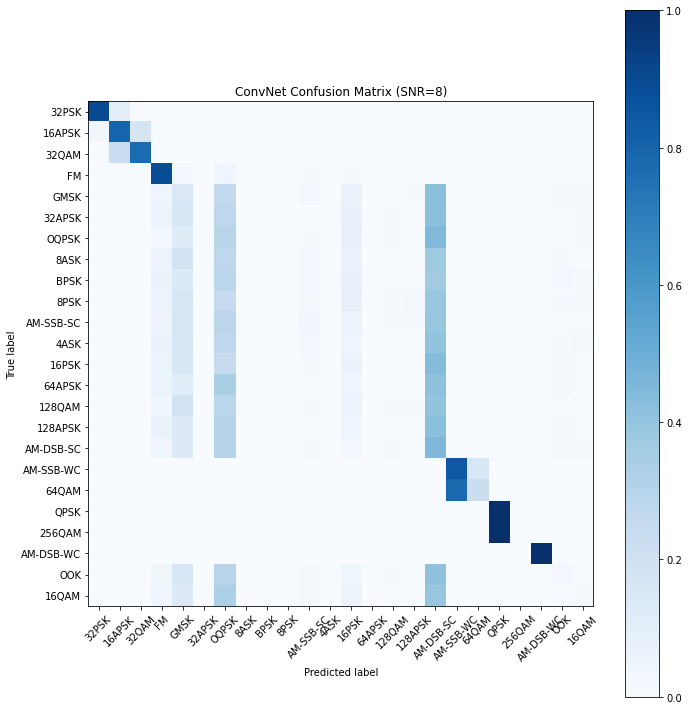

<Figure size 432x288 with 0 Axes>

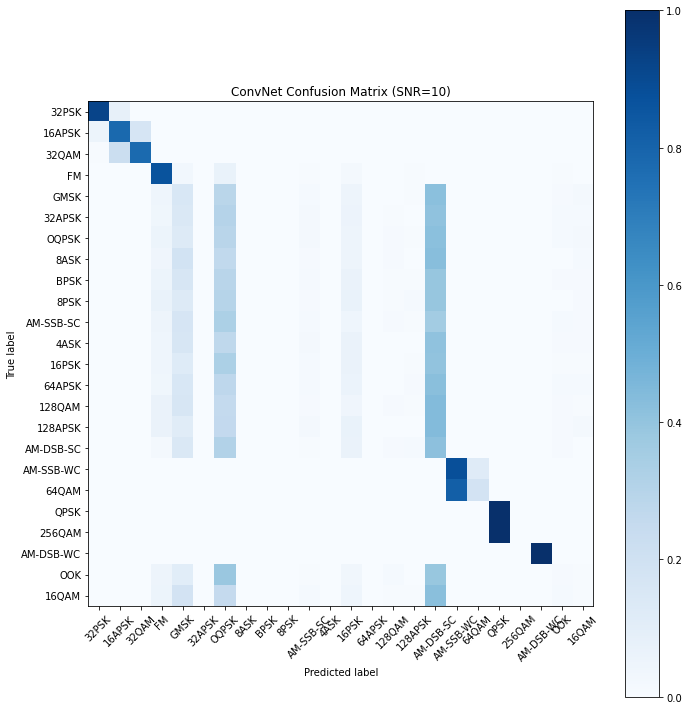

<Figure size 432x288 with 0 Axes>

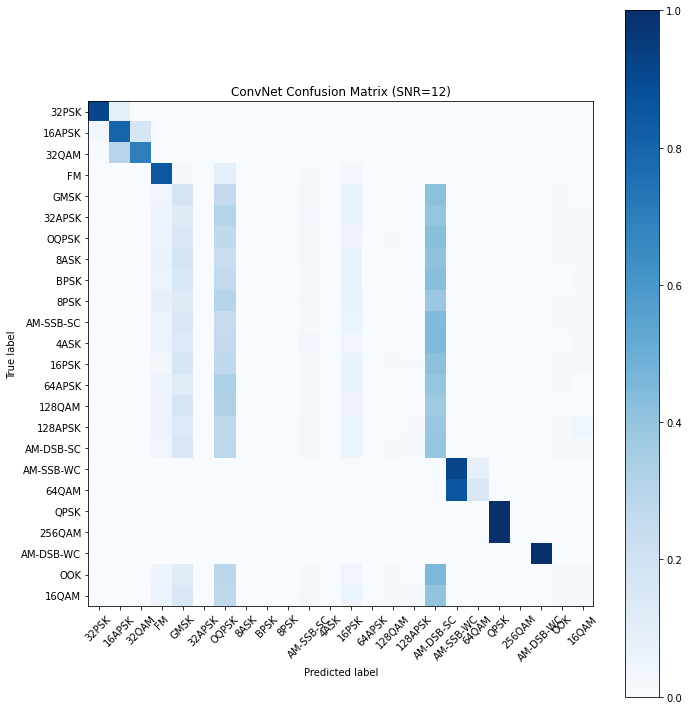

<Figure size 432x288 with 0 Axes>

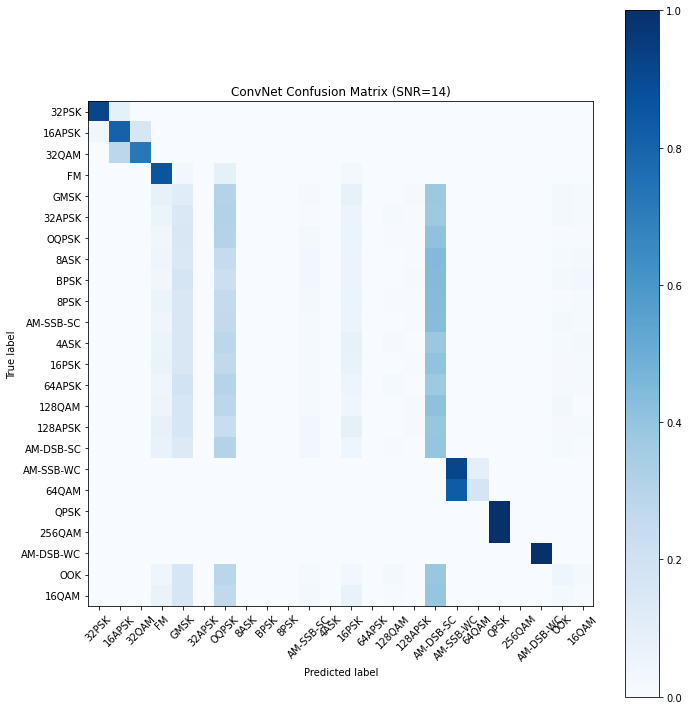

<Figure size 432x288 with 0 Axes>

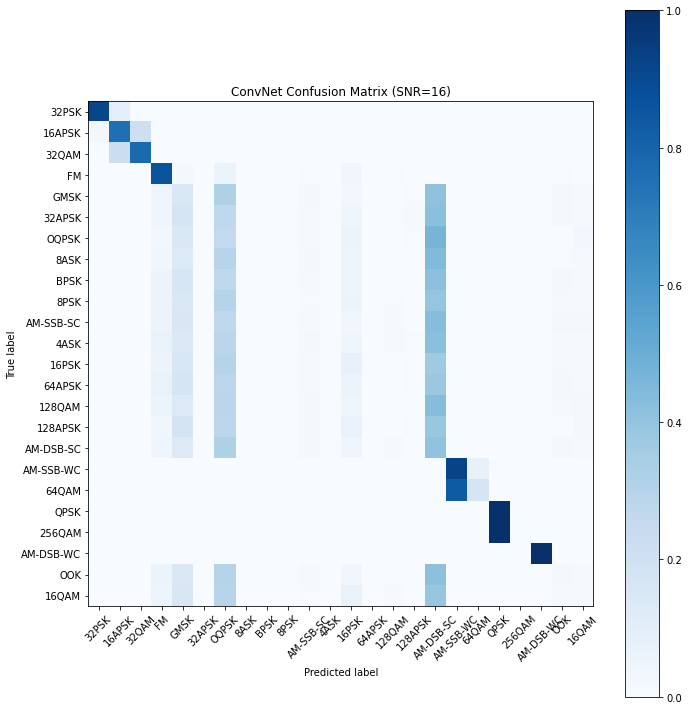

<Figure size 432x288 with 0 Axes>

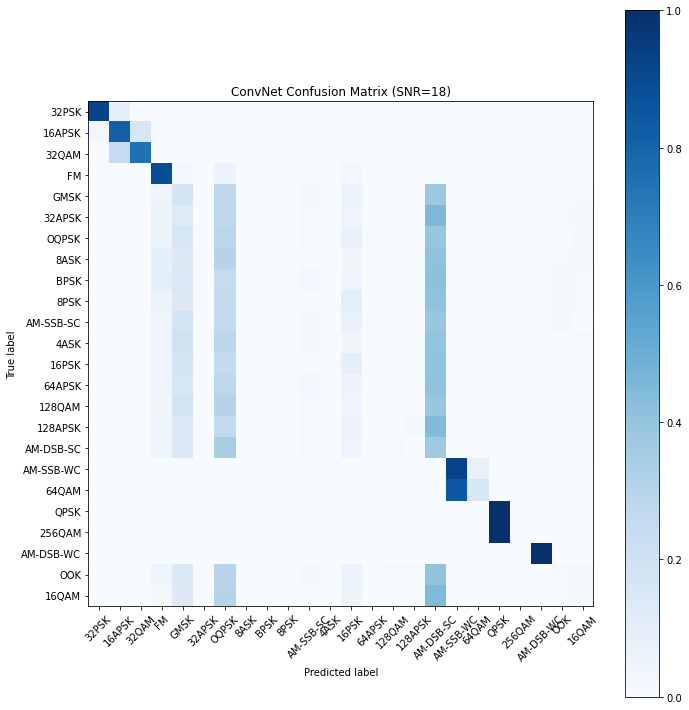

<Figure size 432x288 with 0 Axes>

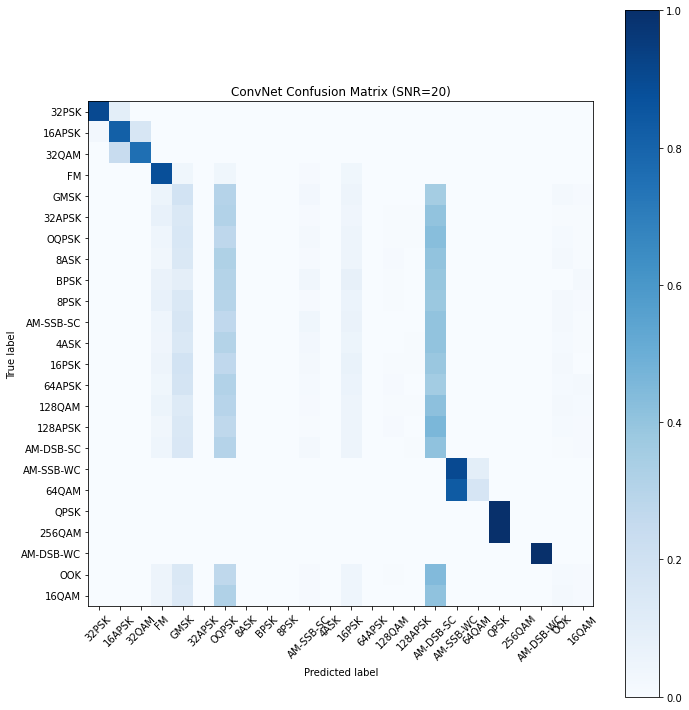

<Figure size 432x288 with 0 Axes>

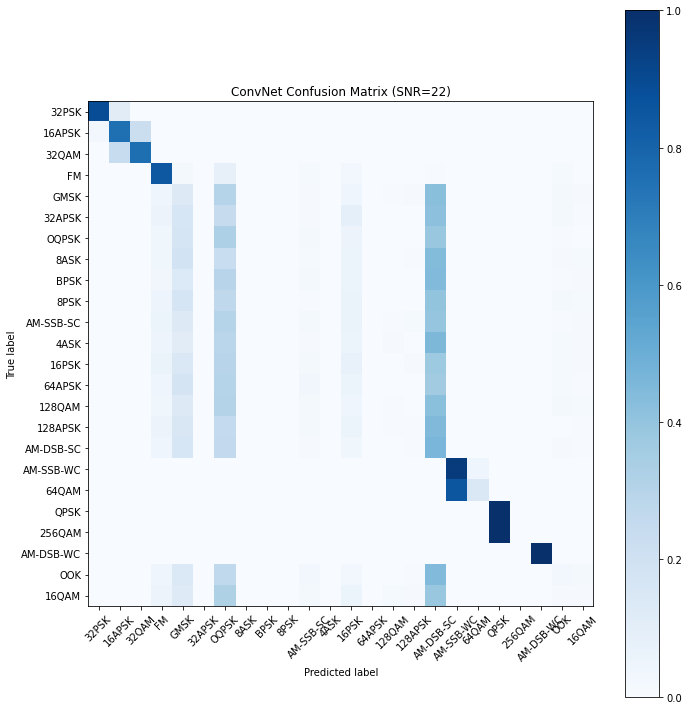

<Figure size 432x288 with 0 Axes>

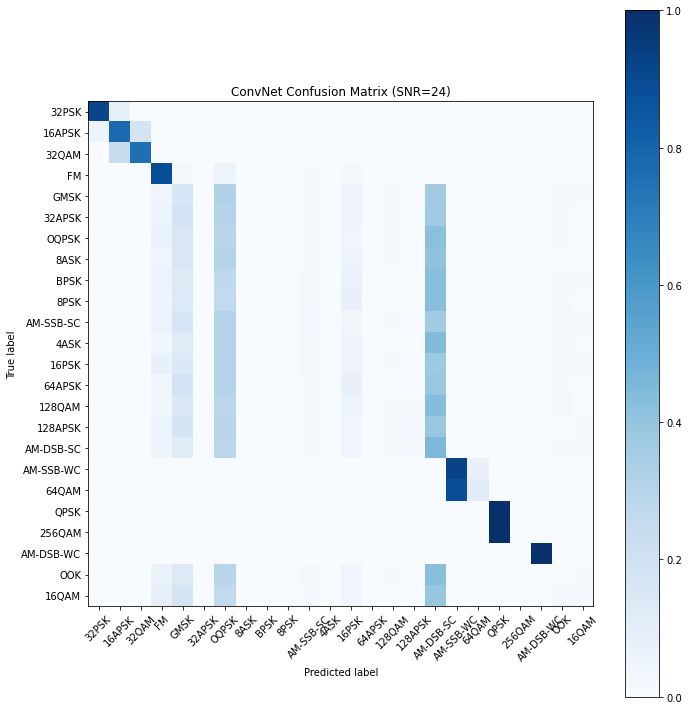

<Figure size 432x288 with 0 Axes>

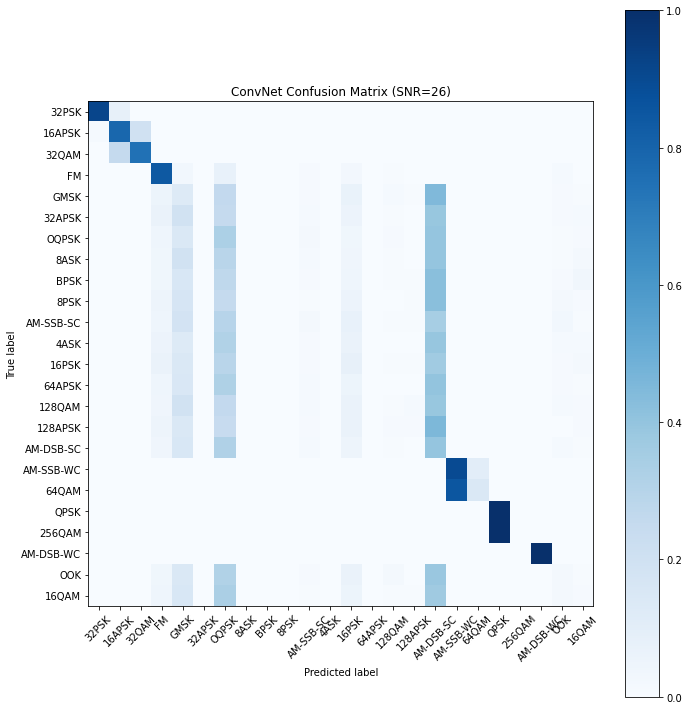

<Figure size 432x288 with 0 Axes>

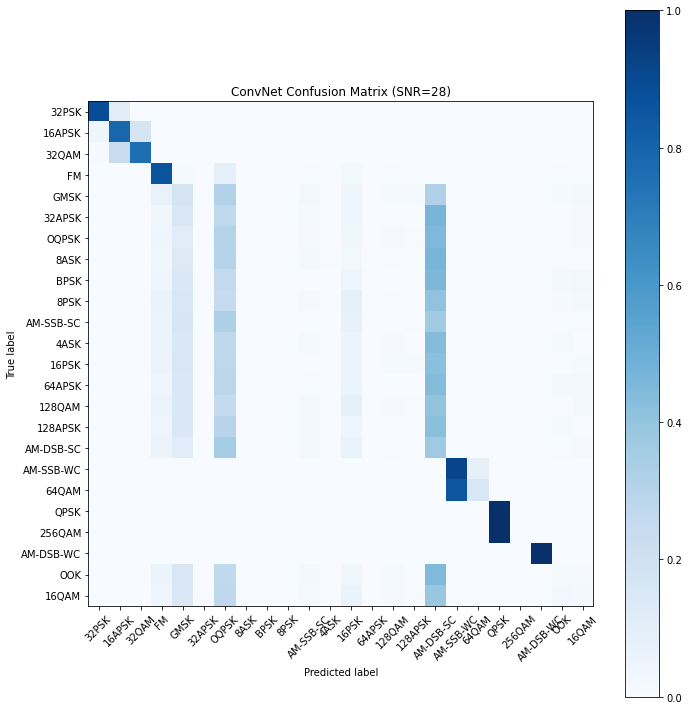

<Figure size 432x288 with 0 Axes>

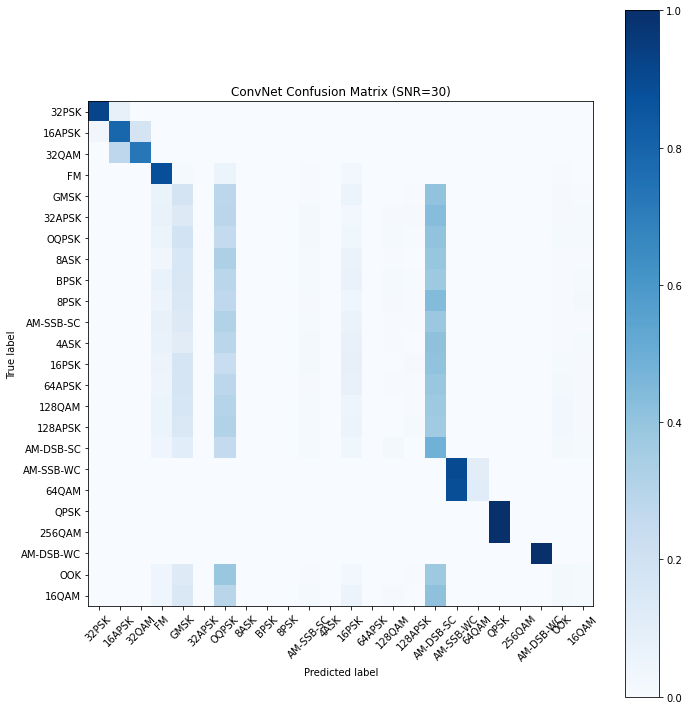

In [37]:

acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #该信噪比下测试数据量
        j = list(Y_test_snr[i,:]).index(1)   #正确类别下标
        k = int(np.argmax(pre_Y_test[i,:])) #预测类别下标
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

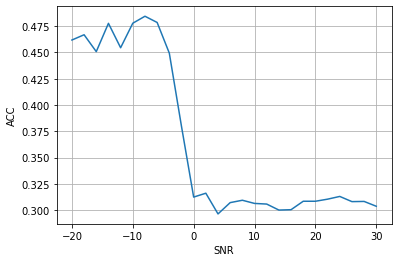

In [38]:

plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.grid(True)
plt.show()